# Routing, speed imputation, and travel times

Including parallelized shortest-path solving via built-in multiprocessing in OSMnx.

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [1]:
import multiprocessing as mp

import numpy as np
import osmnx as ox

np.random.seed(0)
ox.__version__

'2.0.2'

In [2]:
place = "Piedmont, California, USA"
G = ox.graph.graph_from_place(place, network_type="drive")
Gp = ox.projection.project_graph(G)

## 1. Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

In [3]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.convert.to_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [4]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.distance.nearest_nodes(Gp, X, Y, return_dist=True)

In [5]:
# or, find the nearest node to a single point
node = ox.distance.nearest_nodes(Gp, X0, Y0)
node

53021743

In [6]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.distance.nearest_edges(Gp, X, Y, return_dist=True)

In [7]:
# find the nearest edge to a single point
edge = ox.distance.nearest_edges(Gp, X0, Y0)
edge

(53021743, 53021743, 1)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

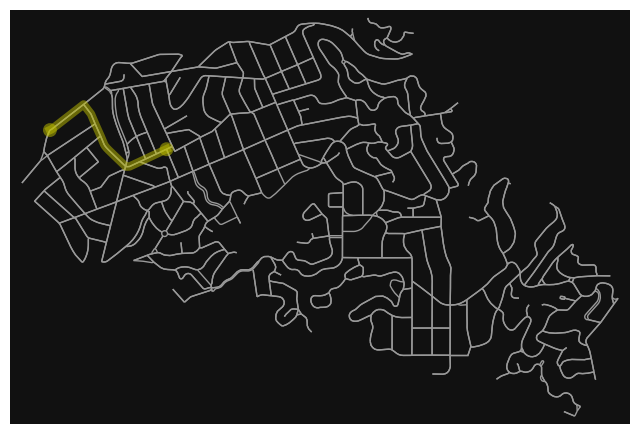

In [8]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.routing.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:

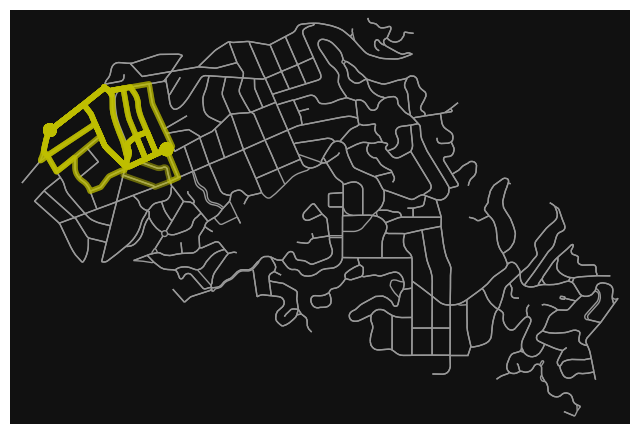

In [9]:
routes = ox.routing.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot.plot_graph_routes(
    G, list(routes), route_colors="y", route_linewidth=4, node_size=0
)

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [10]:
# impute speed on all edges missing data
G = ox.routing.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.routing.add_edge_travel_times(G)

In [11]:
# see mean speed/time values by road type
edges = ox.convert.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
residential,123.1,25.1,17.7
secondary,112.0,44.3,9.2
tertiary,103.6,40.2,9.3
tertiary_link,56.3,36.5,5.6
unclassified,28.7,36.5,2.8


In [12]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [13]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.routing.shortest_path(G, orig, dest, weight="length")
route2 = ox.routing.shortest_path(G, orig, dest, weight="travel_time")

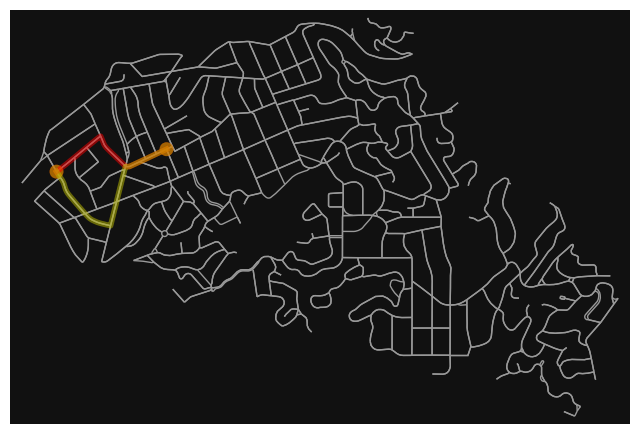

In [14]:
# plot the routes
fig, ax = ox.plot.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [15]:
# compare the two routes
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 766 meters and takes 78 seconds.
Route 2 is 1010 meters and takes 77 seconds.


The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).

## 4. Multiprocessing

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing. With the `shortest_path` function, you can pass in a single origin-destination pair to solve the one shortest path, or you can pass in lists of origins and destinations to solve each shortest path between the pairs.

If you're solving shortest paths for multiple origins/destinations, the `cpus` argument determines how many CPU cores to utilize for parallelized solving. Multiprocessing adds some overhead, but it's faster if you're solving a lot of paths. It also has higher RAM requirements (as it must copy data into each sub-process), so be careful with your RAM when setting the `cpus` argument.

If you are multiprocessing, always remember to protect your entry point. From the [Python docs](https://docs.python.org/3/library/multiprocessing.html#multiprocessing-programming):

> Make sure that the main module can be safely imported by a new Python interpreter without causing unintended side effects (such as starting a new process)... one should protect the “entry point” of the program by using `if __name__ == '__main__':`

In [16]:
# calculate 100,000 shortest-path routes using random origin-destination pairs
n = 100_000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [17]:
# wrap your script in an `if` block to protect the entry point
if __name__ == "__main__":
    # it takes 2.3 seconds to solve all the routes using all the cores on my computer
    # I have a 24-thread AMD 5900x: performance will depend on your specific CPU
    # uncomment below to actually run the code with multiprocessing
    # routes = ox.routing.shortest_path(G, origs, dests, weight="travel_time", cpus=None)
    print(mp.cpu_count())

20


In [18]:
%%time
# it takes 29 seconds to solve all the routes using just 1 core on my computer
routes = ox.routing.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

CPU times: total: 37.7 s
Wall time: 38.8 s


In [19]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

100000
99112


## 5. Miscellaneous routing notes

The routing correctly handles one-way streets:

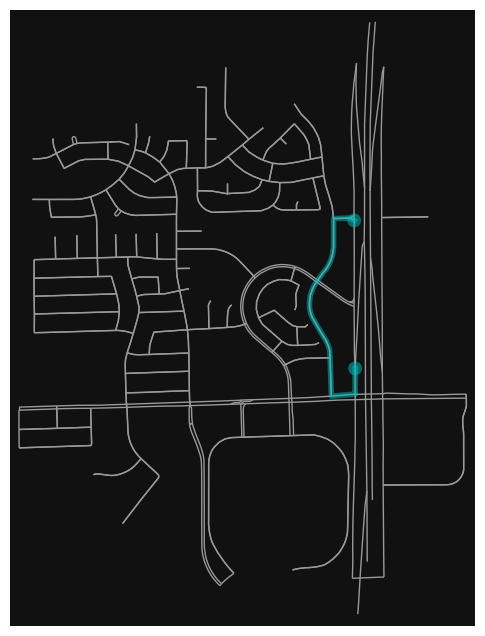

In [20]:
G2 = ox.graph.graph_from_address(
    "N. Sicily Pl., Chandler, Arizona",
    dist=800,
    network_type="drive",
    truncate_by_edge=True,
)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.routing.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot.plot_graph_route(G2, route, route_color="c", node_size=0)

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

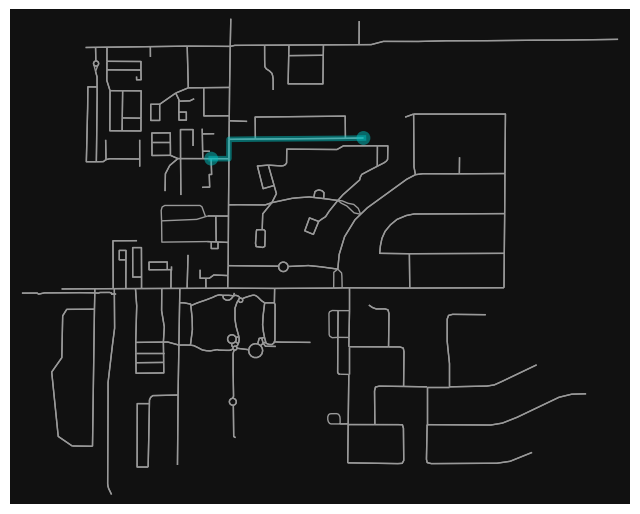

In [21]:
location_point = (33.299896, -111.831638)
G2 = ox.graph.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.routing.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot.plot_graph_route(G2, route, route_color="c", node_size=0)